In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matspy import spy
import json
from recsys_pipeliner.recommendations.transformer import (
    UserItemMatrixTransformer,
    SimilarityTransformer,
)
from recsys_pipeliner.recommendations.recommender import SimilarityRecommender

In [ ]:
# Create a toy dataset
OVERWRITE = False

NUM_USERS = 12
NUM_ITEMS = 24

# Create arrays for each column
rating_options = np.array([0.2, 0.4, 0.6, 0.8, 0.8, 1.0])
users = np.tile(np.expand_dims(np.arange(NUM_USERS), 1), 8)
items = np.arange(NUM_ITEMS)
rated_items = np.array([np.random.choice(items, 8, replace=False) for _ in np.arange(NUM_USERS)])
ratings = np.array([np.random.choice(rating_options, 8) + (n/100) for n in np.arange(NUM_USERS)])
ratings = np.clip(ratings, 0.0, 1.0)

# Stack arrays to get (user, item, rating) combinations
user_item_ratings_generated = np.dstack([users, rated_items, ratings]).astype(np.float32).reshape((-1, 3))

user_item_ratings_df = pd.DataFrame(
    user_item_ratings_generated, columns=["user_id", "item_id", "rating"]
)
user_item_ratings_df.user_id = user_item_ratings_df.user_id.astype(int).map(
    lambda i: f"U{i + 1:05d}"
)
user_item_ratings_df.item_id = user_item_ratings_df.item_id.astype(int).map(
    lambda i: f"I{i + 1:05d}"
)
if OVERWRITE:
    user_item_ratings_df.to_csv(
        "../../tests/test_data/user_item_ratings_toy.csv", index=False
    )
display(user_item_ratings_df.head(12))

,user_id,item_id,rating
0,U00001,I00024,0.80
1,U00001,I00013,0.60
2,U00001,I00005,1.00
3,U00001,I00011,0.40
4,U00001,I00015,0.20
5,U00001,I00012,0.20
6,U00001,I00018,0.80
7,U00001,I00023,1.00
8,U00002,I00012,1.00
9,U00002,I00015,0.81


In [4]:
users = user_item_ratings_df.user_id.unique()
items = user_item_ratings_df.item_id.unique()
user_item_matrix_transformer = UserItemMatrixTransformer()
user_item_matrix = user_item_matrix_transformer.transform(
    user_item_ratings_generated
)
user_item_matrix_df = pd.DataFrame(
    user_item_matrix, index=users, columns=items
).astype(np.float32)
user_item_matrix_df.index.name = "user_id"
display(user_item_matrix_df)

if OVERWRITE:
    user_item_matrix_df.to_csv(
        "../../tests/test_data/user_item_matrix_toy.csv", index=True
    )

user_similarity_matrix_transformer = SimilarityTransformer()
user_similarity_matrix = user_similarity_matrix_transformer.transform(user_item_matrix)
user_similarity_matrix_df = pd.DataFrame(
    user_similarity_matrix, index=users, columns=users
).astype(np.float32)
user_similarity_matrix_df.index.name = "user_id"
display(user_similarity_matrix_df)

if OVERWRITE:
    user_similarity_matrix_df.to_csv(
        "../../tests/test_data/user_similarity_matrix_toy.csv", index=True
    )

item_similarity_matrix_transformer = SimilarityTransformer()
item_similarity_matrix = item_similarity_matrix_transformer.transform(
    user_item_matrix.T
)
item_similarity_matrix_df = pd.DataFrame(
    item_similarity_matrix, index=items, columns=items
).astype(np.float32)
item_similarity_matrix_df.index.name = "item_id"
display(item_similarity_matrix_df)

if OVERWRITE:
    item_similarity_matrix_df.to_csv(
        "../../tests/test_data/item_similarity_matrix_toy.csv", index=True
    )

,I00024,I00013,I00005,I00011,I00015,I00012,I00018,I00023,I00022,I00003,...,I00006,I00004,I00008,I00001,I00002,I00021,I00020,I00010,I00007,I00009
user_id,,,,,,,,,,,,,,,,,,,,,
U00001,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.20,0.00,0.00,0.80,0.00,0.00,0.00,0.00,1.00,0.80
U00002,0.00,0.00,0.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.81,0.00,1.00,0.81,0.41,0.00,0.00,0.61,0.00,0.00
U00003,0.00,0.00,0.82,1.00,0.00,0.82,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.62,0.00,0.00,0.00,0.00,0.62
U00004,0.63,0.00,0.00,0.43,0.00,0.00,0.00,0.63,0.00,0.00,...,0.43,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.63
U00005,0.00,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.44,...,1.00,0.64,0.00,0.00,0.00,0.24,0.24,0.64,0.00,0.00
U00006,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.65,0.00,0.25,...,0.00,0.00,0.00,0.00,0.85,0.85,0.00,0.00,0.65,0.00
U00007,0.00,0.00,0.00,0.00,0.00,0.00,0.86,0.46,0.00,0.00,...,0.66,0.46,0.00,0.00,0.00,0.00,0.86,0.46,0.00,1.00
U00008,0.00,1.00,0.00,0.00,0.00,0.00,0.67,0.87,0.87,0.00,...,0.87,0.00,0.00,0.87,1.00,0.00,0.00,0.00,1.00,0.00
U00009,0.88,1.00,0.00,0.00,0.88,0.00,0.00,0.00,0.00,0.28,...,0.00,0.88,0.00,0.00,0.00,0.00,0.00,0.00,0.48,0.88


,U00001,U00002,U00003,U00004,U00005,U00006,U00007,U00008,U00009,U00010,U00011,U00012
user_id,,,,,,,,,,,,
U00001,1.000000,0.225625,0.179052,0.326486,0.053983,0.347095,0.270623,0.373040,0.535065,0.280126,0.389972,0.036487
U00002,0.225625,1.000000,0.298071,0.086459,0.470338,0.280091,0.355926,0.314586,0.000000,0.534868,0.416813,0.534112
U00003,0.179052,0.298071,1.000000,0.524739,0.332251,0.166056,0.223204,0.104277,0.288133,0.317731,0.488826,0.257561
U00004,0.326486,0.086459,0.524739,1.000000,0.320927,0.282542,0.453145,0.204424,0.576770,0.073198,0.231548,0.231037
U00005,0.053983,0.470338,0.332251,0.320927,1.000000,0.158928,0.373577,0.315466,0.333003,0.128218,0.365108,0.313831
U00006,0.347095,0.280091,0.166056,0.282542,0.158928,1.000000,0.219571,0.430160,0.155166,0.322963,0.174131,0.543880
U00007,0.270623,0.355926,0.223204,0.453145,0.373577,0.219571,1.000000,0.294199,0.292938,0.227594,0.296276,0.249021
U00008,0.373040,0.314586,0.104277,0.204424,0.315466,0.430160,0.294199,1.000000,0.274612,0.131229,0.242746,0.601516
U00009,0.535065,0.000000,0.288133,0.576770,0.333003,0.155166,0.292938,0.274612,1.000000,0.112946,0.190540,0.084844


,I00024,I00013,I00005,I00011,I00015,I00012,I00018,I00023,I00022,I00003,...,I00006,I00004,I00008,I00001,I00002,I00021,I00020,I00010,I00007,I00009
item_id,,,,,,,,,,,,,,,,,,,,,
I00024,1.000000,0.513670,0.000000,0.229950,0.537162,0.000000,0.000000,0.226740,0.000000,0.214497,...,0.140596,0.679630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.207233,0.605412
I00013,0.513670,1.000000,0.000000,0.000000,0.417342,0.000000,0.388249,0.449994,0.660820,0.334255,...,0.569909,0.426684,0.110332,0.355729,0.457300,0.109863,0.076541,0.212462,0.496440,0.310982
I00005,0.000000,0.000000,1.000000,0.449819,0.000000,0.598998,0.000000,0.000000,0.000000,0.345477,...,0.220056,0.412814,0.478604,0.524147,0.277330,0.000000,0.423908,0.585451,0.348792,0.169819
I00011,0.229950,0.000000,0.449819,1.000000,0.000000,0.866101,0.000000,0.153868,0.000000,0.000000,...,0.095410,0.688035,0.000000,0.000000,0.314735,0.000000,0.000000,0.000000,0.000000,0.457831
I00015,0.537162,0.417342,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.174273,...,0.084334,0.304477,0.000000,0.388713,0.000000,0.000000,0.000000,0.000000,0.566977,0.661160
I00012,0.000000,0.000000,0.598998,0.866101,0.000000,1.000000,0.000000,0.000000,0.000000,0.279575,...,0.000000,0.493770,0.076725,0.062583,0.322995,0.000000,0.000000,0.000000,0.051341,0.326978
I00018,0.000000,0.388249,0.000000,0.000000,0.000000,0.000000,1.000000,0.554935,0.578922,0.000000,...,0.592768,0.190052,0.000000,0.346066,0.339602,0.000000,0.535134,0.297949,0.326321,0.441282
I00023,0.226740,0.449994,0.000000,0.153868,0.000000,0.000000,0.554935,1.000000,0.695540,0.094656,...,0.560335,0.272522,0.316977,0.302890,0.796888,0.386757,0.192931,0.107419,0.424308,0.296366
I00022,0.000000,0.660820,0.000000,0.000000,0.000000,0.000000,0.578922,0.695540,1.000000,0.000000,...,0.518767,0.000000,0.189101,0.530431,0.705995,0.000000,0.000000,0.000000,0.500166,0.000000


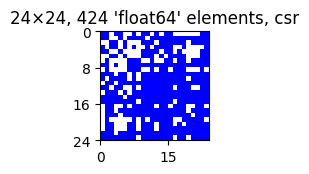

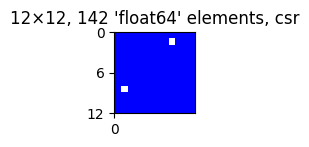

In [5]:
spy(sp.sparse.csr_matrix(item_similarity_matrix))
spy(sp.sparse.csr_matrix(user_similarity_matrix))

In [6]:
item_ids = user_item_matrix_df.columns

item_encoder = LabelEncoder()
item_ids_encoded = item_encoder.fit_transform(item_ids)

similarity_rec = SimilarityRecommender(10)
similarity_rec.fit(item_similarity_matrix)
item_recs = similarity_rec.recommend(item_ids_encoded)

results = [item_encoder.inverse_transform(item).tolist() for item in item_recs]
similarity_recommendations_toy = {item_id: result for item_id, result in zip(item_ids, results)}

if OVERWRITE:
    with open("../../tests/test_data/similarity_recommendations_toy.json", "w") as f:
        f.write(json.dumps(similarity_recommendations_toy, indent=4))

    item_probs = similarity_rec.predict_proba(item_ids_encoded).toarray().astype(np.float32).round(6)
    np.save("../../tests/test_data/similarity_recommendations_toy_probs.npy", item_probs)